In [1]:
# autoreload modules when files have been altered
%load_ext autoreload
%autoreload 2

import ebf, sys, gc
import numpy as np
import pandas as pd
import dill

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

def ErrorWarning():
    raise ValueError("Wait, don't run this, you don't want to!")

# Create New
New database for information.

In [19]:
from seestar import createNew
createNew.create()
# When requested , give the database a path
# Provide a name for the database 
# (I've used Apogee_new here and for the rest of this notebook but you can change that.)

ZipImportError: bad local file header: /home/andy/anaconda2/lib/python2.7/site-packages/seestar-1.2.7rc0-py2.7.egg

# File Info

In [2]:
from seestar import surveyInfoPickler

In [3]:
# Location of fileinfo file - replace teh fileinfo_path string
fileinfo_path = '/media/andy/37E3-0F91/Research/SF/SFdata/Apogee_new/Apogee_new_fileinfo.pickle'
fileinfo = surveyInfoPickler.surveyInformation(fileinfo_path)

In [4]:
# Test for any problems in the
fileinfo.testFiles()
# Good to come back to this whenever you move files around or change things.

1) Checking file paths exist:
OK

2) Checking spectroscopic catalogue file structure:
OK

3) Checking field information file structure:
(make sure halfangle is in units of radians.)
OK

4) Checking photometric catalogue file structure:
Checking 4302.csv:
OK

5) Checking selection function pickle paths exist:
The path to your selection function pickled instance, obsSF_pickle_path, does not exist: /media/andy/37E3-0F91/Research/SF/SFdata/Apogee_new/Apogee_new_obsSF.pickle
The path to your selection function pickled instance, obsSF_pickle_path, does not exist: /media/andy/37E3-0F91/Research/SF/SFdata/Apogee_new/Apogee_new_fieldoverlapdatabase
^ These files should exist for an already made selection function. If you're starting from scratch, ignore this!

6) Checking isochrone pickle files exist:
The premade interpolants (isochrone_interpolantinstances.pickle) will be automatically be used to calculate the selection function.


In [10]:
# Some changes will be saved automatically if you run testFiles then save. 
fileinfo.save()

In [7]:
# Joins some of the given folders and filenames together to create full paths
fileinfo()

# Field info

In [1]:
# Field file downloaded from website
filepath = '/media/andy/UUI/Research/SF/SFdata/APOGEE_learnt/allPlates-l31c.2.fits'

In [2]:
# Generate dataframe from file
from astropy.table import Table

with open(filepath) as data:
    dat = Table.read(data, format='fits')
    
    arr = dat.as_array()
    lstlst = [list(row)[:15]+list(row)[16:] for row in arr.tolist()]
    pointings = pd.DataFrame(lstlst, columns=dat.colnames[:15]+dat.colnames[16:])

IOError: [Errno 2] No such file or directory: '/media/andy/UUI/Research/SF/SFdata/APOGEE_learnt/allPlates-l31c.2.fits'

In [12]:
# Transform from Equatorial to Galactic (Copied from your CoordTrans script in AngleDisks.EquatToGal)
from seestar import AngleDisks

pointings['RADIUS'] *= np.pi/180

pointings['RA'] = pointings.RACEN * np.pi/180
pointings['Dec'] = pointings.DECCEN * np.pi/180
pointings['glon'], pointings['glat'] = AngleDisks.EquatToGal(pointings.RA, pointings.Dec)

/home/andy/.local/lib/python2.7/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


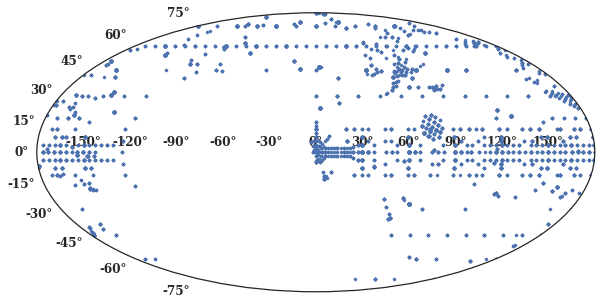

In [13]:
# Scatter of pointings locations
fig = plt.figure(figsize=(10,10))
l = pointings['glon'].copy()
l[l>np.pi] -= 2*np.pi
b = pointings.glat.copy()
plt.subplot(projection='mollweide')
plt.scatter(l, b, s=10)

In [14]:
# Rename columns and provide colour and magnitude boundaries
cols_old = ['LOCATION_ID', 'glon', 'glat', 'RADIUS']
cols_new = ['fieldID', 'glon', 'glat', 'halfangle']
pointings = pointings.rename(index=str, columns=dict(zip(cols_old, cols_new)))
pointings = pointings[cols_new]

pointings['Magmin'] = 'NoLimit'
pointings['Magmax'] = 'NoLimit'
pointings['Colmin'] = 'NoLimit'
pointings['Colmax'] = 'NoLimit'

pointings.drop_duplicates('fieldID', inplace=True)

In [15]:
# Save to csv inside database
pointings.to_csv(fileinfo.field_path, index=False)

# Spectro data

In [44]:
# Spectroscopic datafile which you sent me
filepath = '/media/andy/37E3-0F91/Research/SF/SFdata/APOGEE14/APOGEE_distances_withPRIOR_MASTER_suppapodr14(1).csv'
df = pd.read_csv(filepath)

In [45]:
df.head()

,Unnamed: 0,apogee_id,apogee_location_id,apogee_j,apogee_h,apogee_k,apogee_j_err,apogee_h_err,apogee_k_err,apogee_ra,...,phi_err,z_err,vR_err,vphi_err,vz_err,JR_err,Lz_err,Jz_err,Rc_err,flag
0,0,VESTA,1,-9999.990,-99.999,-9999.990,-9999.990,-9999.990,-9999.990,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,1,2M00000002+7417074,5046,8.597,7.667,7.314,0.039,0.029,0.018,0.000103,...,0.011926,0.037990,2.631136,1.056514,0.954366,4.020780,21.721739,0.805830,0.095030,False
2,2,2M00000019-1924498,5071,11.074,10.740,10.670,0.022,0.026,0.023,0.000832,...,0.000418,0.015165,2.429757,2.120973,0.653616,0.984060,17.627916,0.417470,0.075070,False
3,3,2M00000032+5737103,4264,10.905,10.635,10.483,0.023,0.030,0.022,0.001335,...,0.002175,0.001723,0.492138,0.153465,0.416544,0.068677,3.152596,0.022192,0.013557,False
4,4,2M00000032+5737103,4424,10.905,10.635,10.483,0.023,0.030,0.022,0.001335,...,0.002175,0.001723,0.492138,0.153465,0.416544,0.068677,3.152596,0.022192,0.013557,False


In [46]:
# Relabel columns and correct units (e.g. log10age --> ageGyr)
cols = ['apogee_id', 'apogee_location_id', 'l', 'b', 's', 
            'apogee_j', 'apogee_h', 'apogee_k', 
            'apogee_m_h', 'dm', 'dist', 'par', 'log10_age',
            'mass', 'Z', 'R', 'phi', 'z',  'flag']
df = df[cols].copy()

cols_old = ['apogee_id', 'apogee_location_id', 'l', 'b', 's', 'dist', 'par', 'log10_age', 'mass', 'Z', 'log10_av', 'R', 'phi', 'z']
cols_new = ['APOGEE_ID', 'fieldID', 'glon', 'glat', 's', 'dist', 'par', 'log10age', 'mass', 'Z', 'log10_av', 'R', 'phi', 'z']
df.rename(index=str, columns=dict(zip(cols_old, cols_new)), inplace=True)

cm_old = ['apogee_j', 'apogee_h', 'apogee_k']
cm_new = ['Japp', 'Kapp', 'Happ']
df.rename(index=str, columns=dict(zip(cm_old, cm_new)), inplace=True)

df['ageGyr'] = 10**df['log10age']
# Zsolar = 0.0152
df['mh'] = df.Z

In [ ]:
# Plot scatter of stars on sky to check it's as expected
fig = plt.figure(figsize=(10,10))

plt.subplot(projection='mollweide')
plt.scatter(df.glon, df.glat, s=0.1)

In [11]:
df.head()

,APOGEE_ID,fieldID,glon,glat,s,Japp,Kapp,Happ,apogee_m_h,dm,...,par,log10age,mass,Z,R,phi,z,flag,ageGyr,mh
1,2M00000002+7417074,5046,2.083955,0.205377,3.635099,8.597,7.667,7.314,-0.068105,12.801202,...,0.275633,0.901988,1.090921,-0.054262,10.418575,-0.302025,0.758312,False,7.979728,-0.054262
2,2M00000019-1924498,5071,1.106437,-1.324818,0.248455,11.074,10.740,10.670,-0.182092,6.979364,...,4.025543,0.654352,0.866900,-0.184686,8.173496,-0.006618,-0.227022,False,4.511827,-0.184686
3,2M00000032+5737103,4264,2.025723,-0.079673,0.812791,10.905,10.635,10.483,-0.270533,9.559009,...,1.225693,0.224728,1.618856,-0.253530,8.587034,-0.084856,-0.050081,False,1.677753,-0.253530
4,2M00000032+5737103,4424,2.025723,-0.079673,0.812791,10.905,10.635,10.483,-0.285743,9.559009,...,1.225693,0.224728,1.618856,-0.253530,8.587034,-0.084856,-0.050081,False,1.677753,-0.253530
5,2M00000068+5710233,4264,2.024183,-0.087311,0.745545,10.664,10.132,10.018,-0.122799,9.359217,...,1.343549,0.561265,1.315703,-0.145693,8.551543,-0.078154,-0.050456,False,3.641368,-0.145693


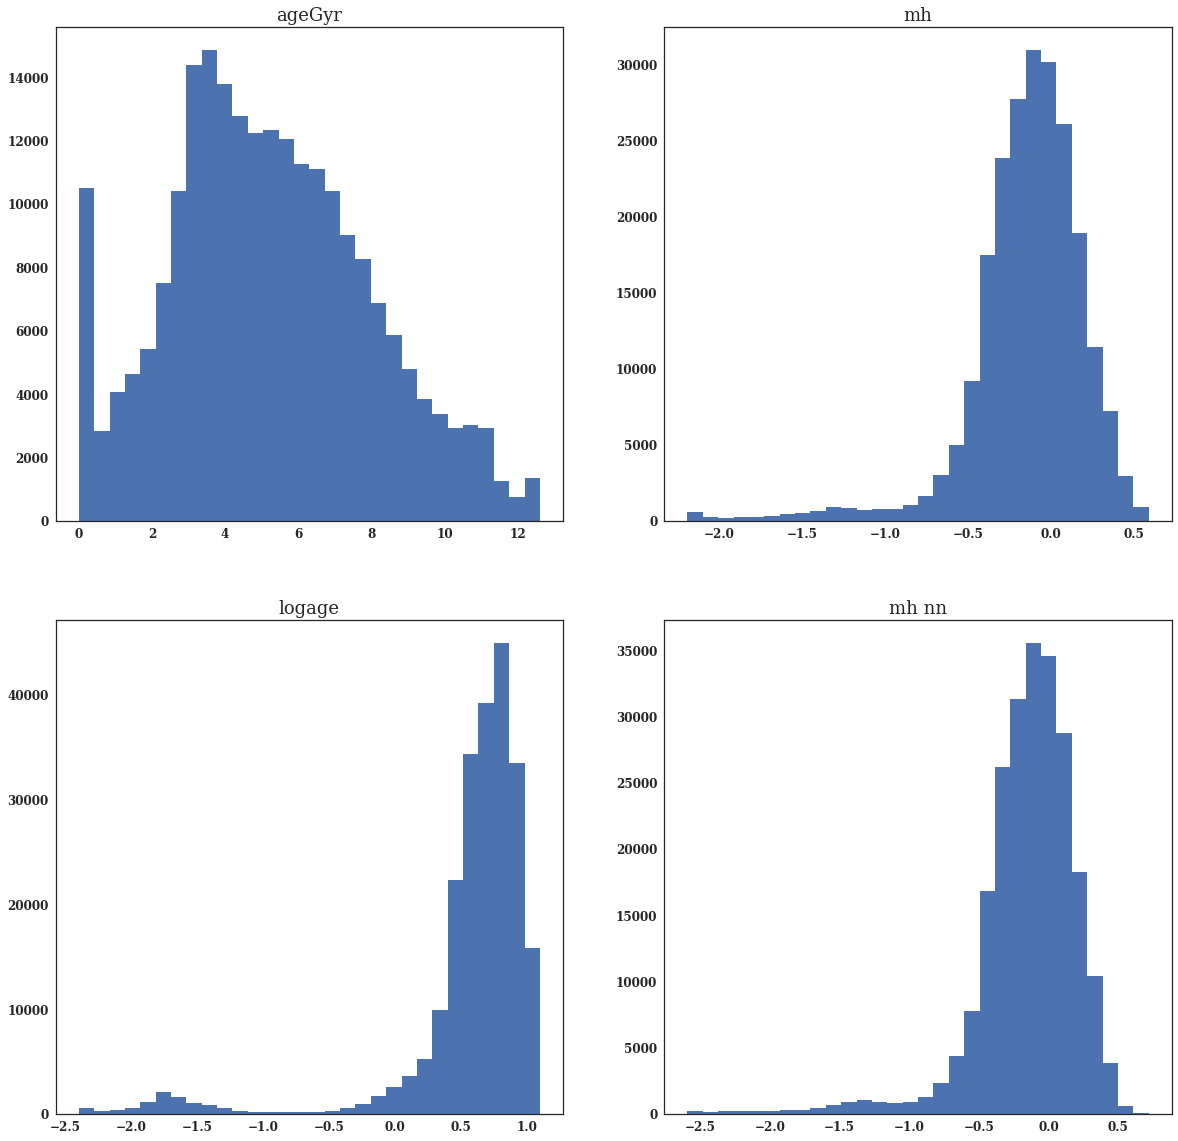

In [47]:
# Check histograms are as expected
fig = plt.figure(figsize=(20, 20))

ax=plt.subplot(221)
_=plt.hist(df.ageGyr[pd.notnull(df.ageGyr)], bins=30)
plt.title('ageGyr')

ax=plt.subplot(222)
_=plt.hist(df.mh[pd.notnull(df.mh)], bins=30)
plt.title('mh')

ax=plt.subplot(223)
_=plt.hist(df.log10age[pd.notnull(df.log10age)], bins=30)
plt.title('logage')

ax=plt.subplot(224)
_=plt.hist(df.apogee_m_h[pd.notnull(df.apogee_m_h) & (df.apogee_m_h>-10)], bins=30)
plt.title('mh nn')

In [48]:
# Lengths of dataframe with various cuts applied
lengths = (len(df), len(df[~df.flag]), 
           len(df[pd.notnull(df.ageGyr)]), len(df[pd.notnull(df.mass)]), len(df[pd.notnull(df.Z)]), len(df[pd.notnull(df.s)]),
            len(df[pd.notnull(df.apogee_m_h) & (df.apogee_m_h>-5)]), 
            len(df[pd.notnull(df.Happ) & (df.Happ>-5)]), 
            len(df[pd.notnull(df.Japp) & (df.Japp>-5)]), 
            len(df[pd.notnull(df.Kapp) & (df.Kapp>-5)]))

# Drop nan values for age and distance and only use flag==False
df = df[pd.notnull(df.ageGyr) & pd.notnull(df.s) & (~df.flag)]
# Only take stars which have normal magnitudes (bad values are -10000)
magcon = (df.Japp<-5000)|(df.Kapp<-5000)|(df.Happ<-5000)
df = df[~magcon]

# Display lengths of various filters
lengths, len(df)

(277371,
 215081,
 224686,
 224686,
 224686,
 222527,
 229285,
 276430,
 276440,
 277370)

In [50]:
df.head()

,APOGEE_ID,fieldID,glon,glat,s,Japp,Kapp,Happ,apogee_m_h,dm,...,par,log10age,mass,Z,R,phi,z,flag,ageGyr,mh
1,2M00000002+7417074,5046,2.083955,0.205377,3.635099,8.597,7.667,7.314,-0.068105,12.801202,...,0.275633,0.901988,1.090921,-0.054262,10.418575,-0.302025,0.758312,False,7.979728,-0.054262
2,2M00000019-1924498,5071,1.106437,-1.324818,0.248455,11.074,10.740,10.670,-0.182092,6.979364,...,4.025543,0.654352,0.866900,-0.184686,8.173496,-0.006618,-0.227022,False,4.511827,-0.184686
3,2M00000032+5737103,4264,2.025723,-0.079673,0.812791,10.905,10.635,10.483,-0.270533,9.559009,...,1.225693,0.224728,1.618856,-0.253530,8.587034,-0.084856,-0.050081,False,1.677753,-0.253530
4,2M00000032+5737103,4424,2.025723,-0.079673,0.812791,10.905,10.635,10.483,-0.285743,9.559009,...,1.225693,0.224728,1.618856,-0.253530,8.587034,-0.084856,-0.050081,False,1.677753,-0.253530
5,2M00000068+5710233,4264,2.024183,-0.087311,0.745545,10.664,10.132,10.018,-0.122799,9.359217,...,1.343549,0.561265,1.315703,-0.145693,8.551543,-0.078154,-0.050456,False,3.641368,-0.145693


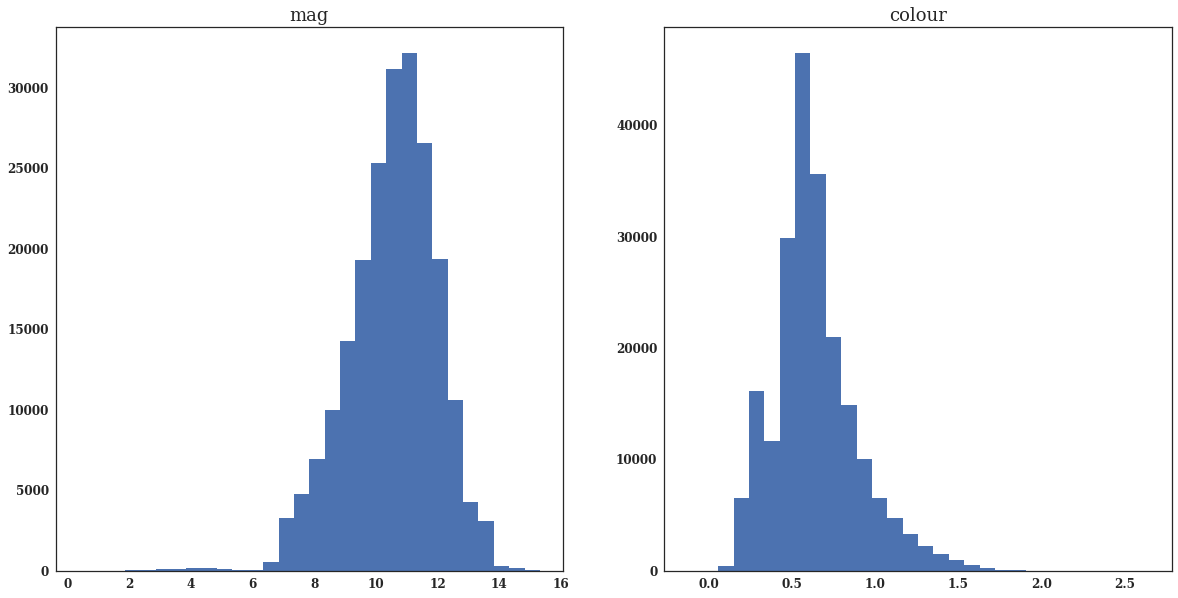

In [55]:
# Check mag and colour histograms are as expected
fig = plt.figure(figsize=(20, 10))

#df = pd.read_csv(fileinfo.spectro_path)
mag = df.Happ
colour = df.Japp - df.Kapp

ax=plt.subplot(121)
_=plt.hist(mag, bins=30)
plt.title('mag')

ax=plt.subplot(122)
_=plt.hist(colour, bins=30)
plt.title('colour')

In [56]:
# Save to spectro file
df.to_csv(fileinfo.spectro_path, index=False)

### Field assignment
Assigning photometric stars to correct fields

In [4]:
from seestar import FieldAssignment
from seestar import ArrayMechanics
from seestar import AngleDisks

In [48]:
pointings = pd.read_csv(fileinfo.field_path)

In [49]:
Nsample = FieldAssignment.iterLimit(len(pointings))

df = ArrayMechanics.AnglePointsToPointingsMatrix(df, pointings, 'glon', 'glat', 'halfangle',
                                                   IDtype=float, progress=True, Nsample=Nsample)

21...248472/258475

# Photometric - 2MASS

In [6]:
files = [str(i*10)+"_"+str((i+1)*10) for i in range(24)]
files.extend([str(i*5)+"_"+str((i+1)*5) for i in range(24*2, 30*2)])
files.extend([str(i*10)+"_"+str((i+1)*10) for i in range(30, 36)])
files = ['/media/andy/UUI/Research/SF/SFdata/2MASS/2MASSfixed/2MASS_'+filen+'.csv.gz' for filen in files]

In [41]:
# Correct 2MASS files to have galactic longitude and latitude in radians

ErrorWarning()
#This is now in the 2MASS folder, please can we ditch it!
Nimport = FieldAssignment.importLimit(files)

Nstars = 0
i = 0
for filepath in files[20:22]:
    i += 1
     
    dtypes = {'j':float, 'h':float, 'k':float}
        
    j = 0
    for df in pd.read_csv(filepath, chunksize=Nimport, low_memory=False):
        
        fname = filepath.split('/')[-1]
    
        j += 1
        Nstars += len(df) 
        sys.stdout.write('\r'+str(i)+'...'+fname+'...'+str(Nstars))
    
        df.RA *= np.pi/180
        df.Dec *= np.pi/180

        df['glon'], df['glat'] = AngleDisks.EquatToGal(df.RA, df.Dec)
        
        if j == 0:
            df.to_csv('/media/andy/UUI/Research/SF/SFdata/2MASS/2MASSgalactic/'+fname, 
                      header=True, index=False, compression='gzip', mode='w')
        else:
            df.to_csv('/media/andy/UUI/Research/SF/SFdata/2MASS/2MASSgalactic/'+fname, 
                      header=False, index=False, compression='gzip', mode='a')
            
        del(df)
        gc.collect()

2...2MASS_210_220.csv.gz...20374829

# Apogee field assignment

In [3]:
files = [str(i*10)+"_"+str((i+1)*10) for i in range(24)]
files.extend([str(i*5)+"_"+str((i+1)*5) for i in range(24*2, 30*2)])
files.extend([str(i*10)+"_"+str((i+1)*10) for i in range(30, 36)])
files = ['/media/andy/UUI/Research/SF/SFdata/2MASS/2MASSgalactic/2MASS_'+filen+'.csv.gz' for filen in files]

In [6]:
FieldAssignment.FieldAssignment(fileinfo_path, files)

Checking photometric catalogue file structure:
Checking /media/andy/UUI/Research/SF/SFdata/2MASS/2MASSgalactic/2MASS_90_100.csv.gz:
Column headers are ['RA' 'Dec' 'j' 'h' 'k' 'glon' 'glat'], 
but photo_coords suggests ['glon', 'glat', 'Japp', 'Kapp', 'Happ'], 
please resolve this.

Tests on the files have raised some warnings. Would you like to continue anyway? (y/n)y

Total number of stars 470000000.
Importing 5310850 stars at a time. Iterating 42264 stars at a time.
Field file path for field 4394: /media/andy/37E3-0F91/Research/SF/SFdata/Apogee_new/photometric/4394.csv
Clearing field files...
...done

File: 2MASS_340_350.csv.gz  Complete: 465745510/470000000(99.095%)  Time: 1020.9m  Projected: 17h10m...Saving: 141/141        
Total stars assigned to fields: 34199298.
Dictionary of stars per field in fileinfo.photo_field_starcount.


<seestar.FieldAssignment.FieldAssignment instance at 0x7f7c00665638>

In [11]:
fileinfo.photo_field_starcount

{2249: 44531,
 2308: 10013,
 4104: 93798,
 4106: 805092,
 4240: 795804,
 4241: 583455,
 4245: 442999,
 4247: 545288,
 4254: 300311,
 4259: 28905,
 4268: 664839,
 4269: 416620,
 4279: 607585,
 4280: 784506,
 4281: 562322,
 4305: 377572,
 4306: 338259,
 4310: 115723,
 4312: 656568,
 4313: 610031,
 4314: 555672,
 4329: 244166,
 4330: 402189,
 4332: 279946,
 4334: 282581,
 4335: 62191,
 4336: 92004,
 4337: 39392,
 4338: 98897,
 4339: 382622,
 4340: 377899,
 4341: 76536,
 4342: 300077,
 4343: 73166,
 4346: 277940,
 4347: 268813,
 4348: 76773,
 4349: 76022,
 4350: 158989,
 4351: 415476,
 4352: 335183,
 4353: 317840,
 4354: 331182,
 4355: 322459,
 4356: 398813,
 4357: 391601,
 4358: 379732,
 4359: 46233,
 4362: 215441,
 4363: 291044,
 4364: 290310,
 4365: 85634,
 4366: 83738,
 4367: 219668,
 4368: 218637,
 4370: 290197,
 4373: 278537,
 4374: 310384,
 4375: 303978,
 4376: 310237,
 4377: 269440,
 4378: 303795,
 4379: 294793,
 4380: 291580,
 4384: 334638,
 4386: 394490,
 4388: 294953,
 4389: 289

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv(files[0], nrows=100)

In [10]:
df.iloc[100:110]

,RA,Dec,j,h,k,glon,glat


In [14]:
round(float(3)/2.5)

1.0

In [18]:
11/2

5